# Bayesian Neural Network  -  Sparse dataset

## Import Libraries

In [4]:
import joblib
import pandas as pd

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split

from matplotlib import pyplot as plt  


In [2]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Sequential

import tensorflow_probability as tfp
tfd = tfp.distributions
tfpl = tfp.layers

import numpy as np

tf.random.set_seed(42)
np.random.seed(42)


2022-08-25 14:46:13.650885: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2022-08-25 14:46:13.655668: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-08-25 14:46:13.655679: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


## Load & Preprocess Dataset 

In [5]:
#load data
data = pd.read_pickle('../../../Data/Sparse_data.pkl')

# Split data traning and target.
y = data['y']
X = data.drop(["y"], axis=1)
#Split data into training and testing sets
test_size = 0.1
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=test_size)

# data shapes summary
print(f"\nTraining Data : {X_train.shape}")
print(f"Testing Data  : {X_test.shape}\n")


Training Data : (8817, 753)
Testing Data  : (980, 753)



## Utils

In [6]:
?tfpl.DenseVariational

# Init signature: tfpl.DenseVariational(*args, **kwargs)
# Docstring:     
# Dense layer with random `kernel` and `bias`.

# This layer uses variational inference to fit a "surrogate" posterior to the
# distribution over both the `kernel` matrix and the `bias` terms which are
# otherwise used in a manner similar to `tf.keras.layers.Dense`.

# This layer fits the "weights posterior" according to the following generative
# process:

# ```none
# [K, b] ~ Prior()
# M = matmul(X, K) + b
# Y ~ Likelihood(M)
# ```
# Init docstring:
# Creates the `DenseVariational` layer.

# Args:
#   units: Positive integer, dimensionality of the output space.
#   make_posterior_fn: Python callable taking `tf.size(kernel)`,
#     `tf.size(bias)`, `dtype` and returns another callable which takes an
#     input and produces a `tfd.Distribution` instance.
#   make_prior_fn: Python callable taking `tf.size(kernel)`, `tf.size(bias)`,
#     `dtype` and returns another callable which takes an input and produces a
#     `tfd.Distribution` instance.
#   kl_weight: Amount by which to scale the KL divergence loss between prior
#     and posterior.
#   kl_use_exact: Python `bool` indicating that the analytical KL divergence
#     should be used rather than a Monte Carlo approximation.
#   activation: Activation function to use.
#     If you don't specify anything, no activation is applied
#     (ie. "linear" activation: `a(x) = x`).
#   use_bias: Boolean, whether the layer uses a bias vector.
#   activity_regularizer: Regularizer function applied to
#     the output of the layer (its "activation")..
#   **kwargs: Extra arguments forwarded to `tf.keras.layers.Layer`.

Init signature: tfpl.DenseVariational(*args, **kwargs)
Docstring:     
Dense layer with random `kernel` and `bias`.

This layer uses variational inference to fit a "surrogate" posterior to the
distribution over both the `kernel` matrix and the `bias` terms which are
otherwise used in a manner similar to `tf.keras.layers.Dense`.

This layer fits the "weights posterior" according to the following generative
process:

```none
[K, b] ~ Prior()
M = matmul(X, K) + b
Y ~ Likelihood(M)
```
Init docstring:
Creates the `DenseVariational` layer.

Args:
  units: Positive integer, dimensionality of the output space.
  make_posterior_fn: Python callable taking `tf.size(kernel)`,
    `tf.size(bias)`, `dtype` and returns another callable which takes an
    input and produces a `tfd.Distribution` instance.
  make_prior_fn: Python callable taking `tf.size(kernel)`, `tf.size(bias)`,
    `dtype` and returns another callable which takes an input and produces a
    `tfd.Distribution` instance.
  kl_weight: 

## Define Prior and Posterior

In [7]:
# Prior is not trainable
def prior(kernel_size, bias_size, dtype = None):
    n = kernel_size + bias_size # num of params
    return Sequential([
       tfpl.DistributionLambda(
           lambda t: tfd.Laplace(loc = tf.zeros(n), scale= 2 * tf.ones(n))
       )                     
  ])

def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    return tf.keras.Sequential([
      tfp.layers.VariableLayer(2 * n, dtype=dtype),
      tfp.layers.DistributionLambda(lambda t: tfd.Independent(

          tfd.Normal(loc=t[..., :n],
                     scale= 1e-5 + 0.003 * tf.nn.softplus(t[..., n:])),
          reinterpreted_batch_ndims=1)),
    ])

## Model 

In [8]:
model = Sequential([
    
    tfpl.DenseVariational(units = 100,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / X_train.shape[0], activation = tf.nn.relu),
    
    tfpl.DenseVariational(units = 100,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / X_train.shape[0], activation = tf.nn.relu),
    
    tfpl.DenseVariational(units = 100,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / X_train.shape[0], activation = tf.nn.relu),
    
    tfpl.DenseVariational(units = 10,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / X_train.shape[0], activation = tf.nn.relu),
    tfpl.DenseVariational(units = 1,
                          make_prior_fn = prior,
                          make_posterior_fn = posterior,
                          kl_weight = 1 / X_train.shape[0])
])

model.build(X_train.shape)
model.compile(loss="mse",
                         optimizer = tf.keras.optimizers.Adam(lr = 0.001),
                         metrics=['mae'])
model.summary()

2022-08-25 14:47:05.956721: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-08-25 14:47:05.956748: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-08-25 14:47:05.956786: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (jupyter-e044432): /proc/driver/nvidia/version does not exist
2022-08-25 14:47:05.957579: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVar  (8817, 100)              150800    
 iational)                                                       
                                                                 
 dense_variational_1 (DenseV  (8817, 100)              20200     
 ariational)                                                     
                                                                 
 dense_variational_2 (DenseV  (8817, 100)              20200     
 ariational)                                                     
                                                                 
 dense_variational_3 (DenseV  (8817, 10)               2020      
 ariational)                                                     
                                                                 
 dense_variational_4 (DenseV  (8817, 1)                2

### Training

In [9]:
history = model.fit(X_train, y_train, epochs=250, verbose=1)

Epoch 1/250
276/276 [==============================] - 4s 6ms/step - loss: 3110755.7500 - mae: 4.8986
Epoch 2/250
276/276 [==============================] - 2s 6ms/step - loss: 2989644.2500 - mae: 2.5051
Epoch 3/250
276/276 [==============================] - 2s 6ms/step - loss: 2879855.2500 - mae: 2.2972
Epoch 4/250
276/276 [==============================] - 2s 6ms/step - loss: 2780453.5000 - mae: 2.1824
Epoch 5/250
276/276 [==============================] - 2s 6ms/step - loss: 2690655.0000 - mae: 2.1567
Epoch 6/250
276/276 [==============================] - 2s 6ms/step - loss: 2608683.2500 - mae: 2.0847
Epoch 7/250
276/276 [==============================] - 2s 6ms/step - loss: 2533785.7500 - mae: 2.0577
Epoch 8/250
276/276 [==============================] - 2s 6ms/step - loss: 2465566.0000 - mae: 2.0219
Epoch 9/250
276/276 [==============================] - 2s 6ms/step - loss: 2402744.5000 - mae: 1.9798
Epoch 10/250
276/276 [==============================] - 2s 6ms/step - loss: 234484

In [10]:
# list all data in history
print(history.history.keys())

dict_keys(['loss', 'mae'])


In [12]:
# Define number of forward passes ( the weighs are distributions now,
# thus each forwad pass will give a different prediciton)
NB_OF_PASSES = 20

y_test_preds = []
y_train_preds = []

for i in range(NB_OF_PASSES):
    y0 = model.predict(X_test)
    y1 = model.predict(X_train)
    y_test_preds.append(y0)
    y_train_preds.append(y1)

276/276 [==============================] - 1s 3ms/step


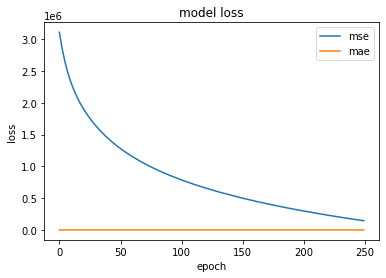

In [13]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['mae'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['mse', 'mae'], loc='upper right')
plt.show()

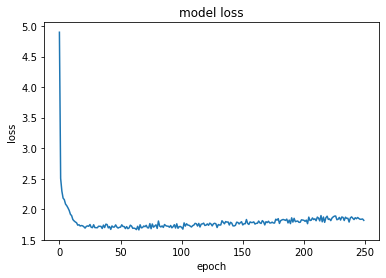

In [14]:
# summarize history for loss

plt.plot(history.history['mae'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

In [15]:
# convert to numpy arrays to compute metrics
y_test_preds = np.array(y_test_preds)
y_train_preds = np.array(y_train_preds)

In [16]:
# reshape arrays to remove the last dimension / (20,732,1) => (20,732)
y_test_preds = np.reshape(y_test_preds,
                          (y_test_preds.shape[0],y_test_preds.shape[1]))

In [17]:
# verifiy shape
y_test_preds.shape

(20, 980)

In [18]:
# get the means and stds
test_prediction_means = np.mean(y_test_preds, axis=0).reshape(y_test.shape)
test_prediction_stds = np.std(y_test_preds, axis=0).reshape(y_test.shape)

train_prediction_means = np.mean(y_train_preds, axis=0).reshape(y_train.shape)
train_prediction_stds = np.std(y_train_preds, axis=0).reshape(y_train.shape)

In [19]:
test_prediction_means.shape

(980,)

In [21]:
import seaborn as sns

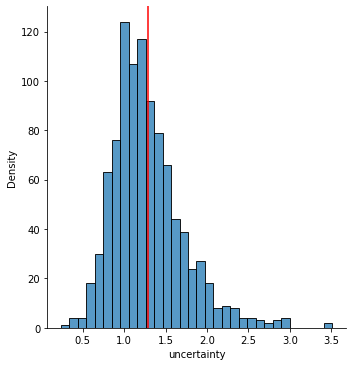

In [22]:
#plt.figure(figsize=(10,8))
sns.displot(test_prediction_stds)
plt.axvline(np.mean(test_prediction_stds), color='red')
#plt.legend(['mean of stdvs','std for each tire preds'])
plt.xlabel("uncertainty")
plt.ylabel("Density")
plt.show()

In [24]:

# goat3 import methods
from goat3.pipeline import PandasPipeline, ColumnsSelector
from goat3.validation import plot_adequation, plot_residuals, plot_confidence, plot_confidence_v2, plot_cumulative
from goat3.metamodel import KerasRegressorGoat, BaggingRegressorGoat
from goat3 import create_fully_connected
from goat3.validation._validation import table_results

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

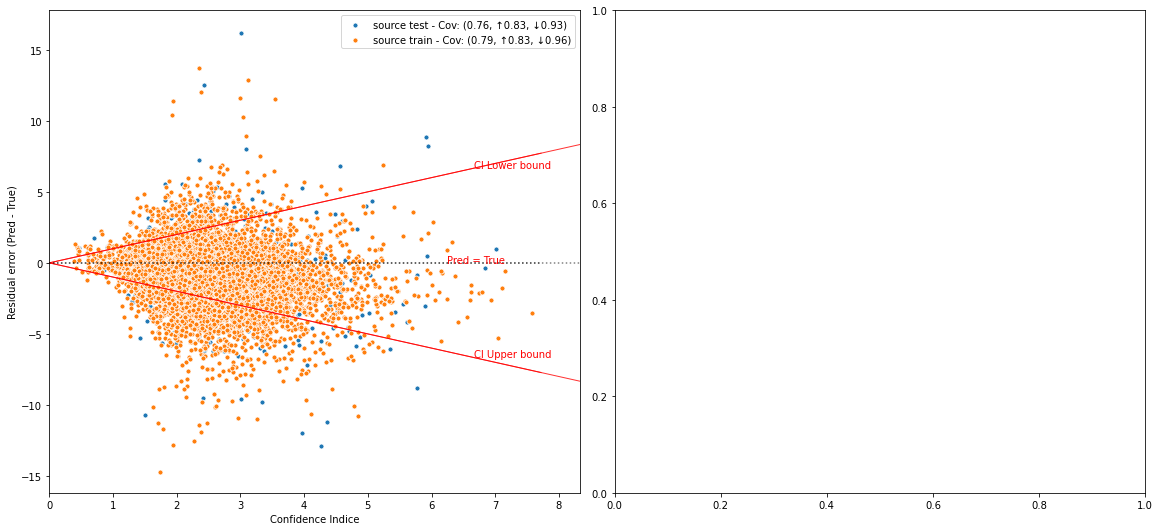

In [25]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0]);  ax3 = fig.add_subplot(gs[0, 1])

plot_confidence_v2(y_test, test_prediction_means,
                   test_prediction_means-2*test_prediction_stds,
                   test_prediction_means+2*test_prediction_stds,
                   ax=ax1,
                   label='source test')
plot_confidence_v2(y_train, train_prediction_means,
                   train_prediction_means-2*train_prediction_stds,
                   train_prediction_means+2*train_prediction_stds,
                   ax=ax1,
                   label='source train')

In [26]:
import uncertainty_toolbox as uct

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

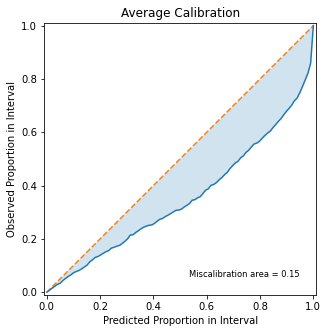

In [27]:
uct.viz.plot_calibration(test_prediction_means,  test_prediction_stds , np.array(y_test))

In [28]:
recalibrator = uct.recalibration.get_std_recalibrator(test_prediction_means, test_prediction_stds, np.array(y_test), criterion='ma_cal')
new_stds = recalibrator(np.array(test_prediction_stds))

<AxesSubplot:title={'center':'Average Calibration'}, xlabel='Predicted Proportion in Interval', ylabel='Observed Proportion in Interval'>

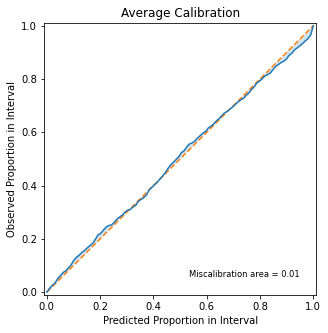

In [29]:
uct.viz.plot_calibration(test_prediction_means, new_stds, np.array(y_test))

<AxesSubplot:xlabel='Confidence Indice', ylabel='Residual error (Pred - True)'>

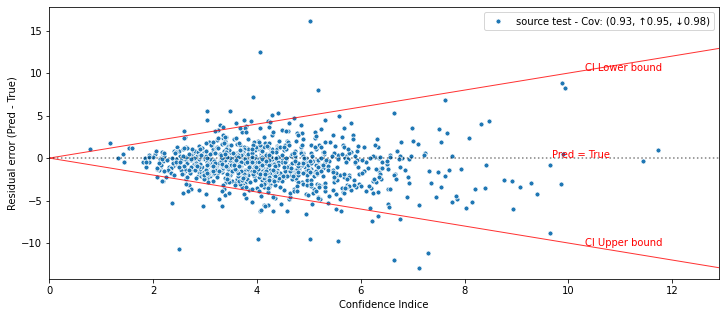

In [30]:
plot_confidence_v2(y_test, test_prediction_means , test_prediction_means-2*new_stds, test_prediction_means+2*new_stds, label='source test')

In [31]:
metrics = uct.metrics.get_all_metrics(test_prediction_means, np.array(new_stds), np.array(y_test))

 (1/n) Calculating accuracy metrics
 (2/n) Calculating average calibration metrics
 (3/n) Calculating adversarial group calibration metrics
  [1/2] for mean absolute calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.04it/s]


  [2/2] for root mean squared calibration error
Measuring adversarial group calibration by spanning group size between 0.0 and 1.0, in 10 intervals


100%|██████████| 10/10 [00:01<00:00,  7.24it/s]


 (4/n) Calculating sharpness metrics
 (n/n) Calculating proper scoring rule metrics
**Finished Calculating All Metrics**


===================== Accuracy Metrics =====================
  MAE           1.790
  RMSE          2.512
  MDAE          1.352
  MARPD         13.776
  R2            0.701
  Correlation   0.857
=============== Average Calibration Metrics ================
  Root-mean-squared Calibration Error   0.013
  Mean-absolute Calibration Error       0.011
  Miscalibration Area                   0.011
========== Adversarial Group Calibration Metrics ===========
  Mean-absolute Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.051
     Group Size: 0.56 -- Calibration Error: 0.022
     Group Size: 1.00 -- Calibration Error: 0.011
  Root-mean-squared Adversarial Group Calibration Error
     Group Size: 0.11 -- Calibration Error: 0.064
     Group Size: 0.56 -- Calibration Error: 0.025
     Group Size: 1.00 -- Calibration Error: 0.013
===============

<AxesSubplot:xlabel='Residual error', ylabel='Density'>

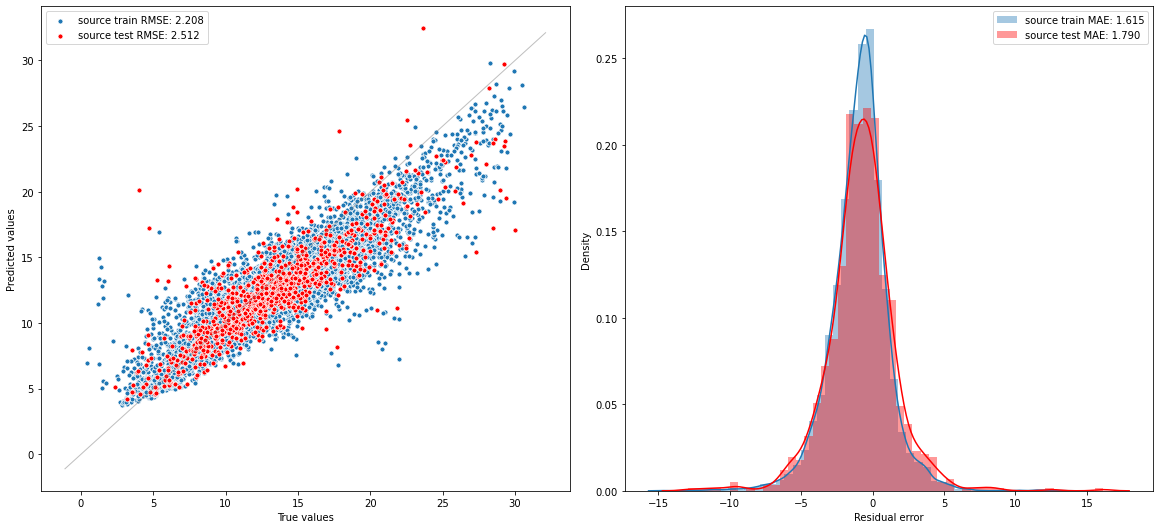

In [32]:
fig = plt.figure(constrained_layout=True, figsize=(16, 14))
gs = fig.add_gridspec(2, 2)

ax1 = fig.add_subplot(gs[0, 0]);  ax3 = fig.add_subplot(gs[0, 1]);

plot_adequation(y_train, train_prediction_means, label='source train', ax=ax1, score='RMSE')
plot_adequation(y_test, test_prediction_means, label='source test', ax=ax1, plot_line=False,color='red', score='RMSE')


plot_residuals(y_train, train_prediction_means, kind='hist', label='source train', ax=ax3, score='MAE')
plot_residuals(y_test, test_prediction_means, kind='hist', label='source test', ax=ax3, color = 'red', score='MAE')

In [33]:
import pickle
with open('BNN_metrics_sparse.pkl', 'wb') as f:
    pickle.dump(metrics, f)